<a href="https://colab.research.google.com/github/booorayan/naive_bayes_knn/blob/master/Predicting_Survival_of_Passengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the Survival of Passengers Using Titanic Dataset

## Defining the Question

## Importing the Required Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import metrics

In [0]:
# enabling mulitple display in the same cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Loading the Dataset

In [0]:
# loading the csv file as a dataframe using pd.read_csv function
titan = pd.read_csv('train.csv')



In [246]:
# previewing the first and last five observations in the train dataset
# previewing the first five observations in the dataset
print('\033[1m  First Five Observations:\033[0m \n')
titan.head()

# previewing the last five observations 
print('\n\n\n\033[1m  Last Five Observations:\033[0m \n' )
titan.tail()

  First Five Observations: 



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S





  Last Five Observations: 



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


## Exploring & Tidying the Dataframe

In [247]:
# checking the names of columns in the dataframe
titan.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [248]:
# changing the column names to lowercase
titan.columns = titan.columns.str.lower()
titan.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [249]:
# checking the number of rows and columns and total no. of observations in the dataframe
print('No. of rows:', titan.shape[0])
print('No. of columns:', titan.shape[1])
print('Total no. of observations:', titan.size)

No. of rows: 891
No. of columns: 12
Total no. of observations: 10692


In [250]:
# checking if the columns have the correct datatypes
titan.dtypes

passengerid      int64
survived         int64
pclass           int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
dtype: object

In [251]:
# checking the no. of non-null values in the datframe
titan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
passengerid    891 non-null int64
survived       891 non-null int64
pclass         891 non-null int64
name           891 non-null object
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
ticket         891 non-null object
fare           891 non-null float64
cabin          204 non-null object
embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


From the output, we can see that some columns have null values (i.e cabin, age and embarked). The cabin column has a very high number of null values

The dataframe has 2 columns of float datatype(i.e. fare & age), five integer columns(i.e. passengerid, survived, pclass, sibsp & parch) and 5 object columns (i.e. name, sex, ticket, cabin & embarked)

In [252]:
# checking for number of missing values in each column
titan.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

The age column has 177 null values, the cabin column 687 and the embarked column has 2 null values

In [253]:
# renaming the column passengerid to passenger_id
titan.rename({'passengerid': 'passenger_id'}, axis=1, inplace=True) 
titan.columns

Index(['passenger_id', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [254]:
# dropping the ticket and cabin column based on the assumption that the two don't influence the cahnces of survival
taitan = titan.drop(['ticket', 'cabin', 'passenger_id'], axis=1)

# previewing the resulting dataframe
taitan.head()

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [255]:
# usin regular expressions to extract the title of passengers form the name column.
# expand = False returns a dataframe
taitan['title'] = taitan.name.str.extract('([A-Za-z]+)\.', expand=False)
taitan.tail()

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,title
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.00,S,Rev
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.00,S,Miss
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.45,S,Miss
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.00,C,Mr
890,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,7.75,Q,Mr


In [256]:
# replacing some of the titles with general names

taitan['title'] = taitan.title.replace(to_replace=[['Lady', 'Countess', 'Capt', 'Col',\
                                                  'Don', 'Dr', 'Major', 'Rev', 'Sir',\
                                                  'Jonkheer', 'Dona']],\
                                       value='Royalty')
taitan['title'].replace(to_replace='Mlle', value='Miss', inplace=True)
taitan['title'].replace(to_replace='Ms', value='Miss', inplace=True)
taitan['title'].replace(to_replace='Mme', value='Mrs', inplace=True)

# confirming changes were effected
taitan.title.unique()
print('\n')
taitan.title.value_counts()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty'], dtype=object)

Mr         517
Miss       185
Mrs        126
Master      40
Royalty     23
Name: title, dtype: int64

In [257]:
# a frequency table showing number of passengers grouped by title
pd.crosstab(taitan['title'], taitan['sex'])

sex,female,male
title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Royalty,3,20


The title column now has five unique values

The titles of most passengers was Mr, Miss and Mrs

In [258]:
# dropping the name column as it now has little influence on the outcome survival
taitan.drop('name', 1, inplace=True)
taitan.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [259]:
# selecting passengers that survived the accident
taitan_filt = taitan[taitan.survived == 1]

# grouping passengers by their title and getting the total no. of survivors
taitan_filt[['title', 'survived']].groupby('title').count().reset_index()

,title,survived
0,Master,23
1,Miss,130
2,Mr,81
3,Mrs,100
4,Royalty,8


In [260]:
# mapping numerical values to the categorical values in the title column
# 'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Royalty': 5
title_map = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Royalty': 5}
taitan['title'] = taitan['title'].map(title_map)

# confirming change has been effected
taitan.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,3
2,1,3,female,26.0,0,0,7.9250,S,2
3,1,1,female,35.0,1,0,53.1000,S,3
4,0,3,male,35.0,0,0,8.0500,S,1


A significant proportion of Mrs and Miss survived the accident (These two groups suffered the least casualties)

In [261]:
taitan.title.unique()

array([1, 3, 2, 4, 5])

In [262]:
# encoding sex column with numerical values and changing their datatype to integer
# male represented by 0 and female mapped to value 1
taitan['sex'] = taitan['sex'].map({'female':1, 'male':0}).astype(int)
taitan.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


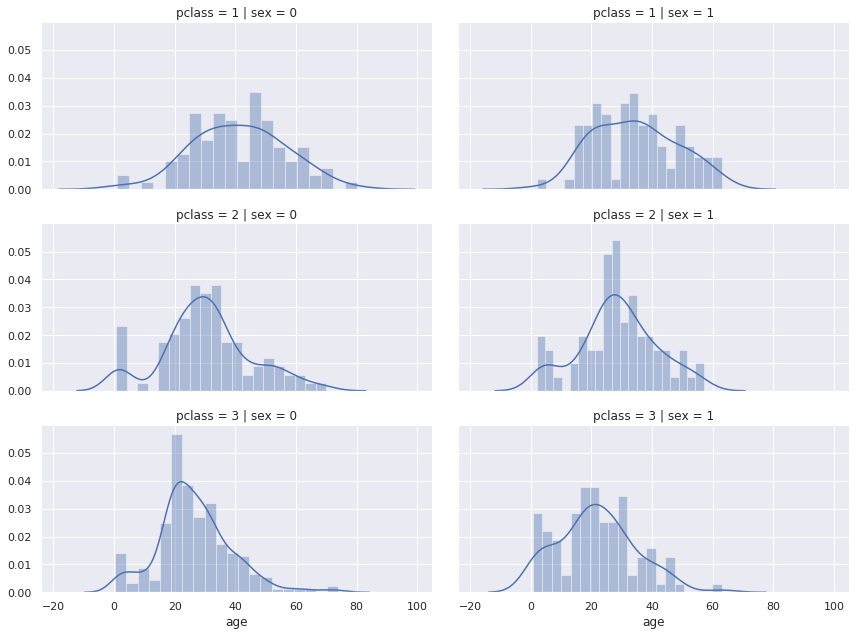

In [263]:
# looking at distribution to get a picture of how to fill missing values
miss_grid = sns.FacetGrid(taitan, row='pclass', col='sex', height=3, aspect=2)
miss_grid.map(sns.distplot, 'age', bins=20)
miss_grid.add_legend()
plt.show();

In [264]:
# joining the sibsp and parch columns also makes sense as it'll\
# display the total no. of relatives one has on the ship

# creating a new column called relatives. the column is a sum of two columns: sibsp and parch
taitan['relatives'] = taitan['sibsp'] + taitan['parch']

# creating a new column, alone that tells whether a passenger had relatives or not
# 0 shows that passenger was not alone
# 1 shows passenger was alone
taitan.loc[taitan['relatives'] > 0, 'alone'] = 0
taitan.loc[taitan['relatives'] == 0, 'alone'] = 1

# changing datatype pf column to integer
taitan.alone = taitan['alone'].astype(int)
taitan.head()
print('===='*20)
taitan.alone.value_counts()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,title,relatives,alone
0,0,3,0,22.0,1,0,7.2500,S,1,1,0
1,1,1,1,38.0,1,0,71.2833,C,3,1,0
2,1,3,1,26.0,0,0,7.9250,S,2,0,1
3,1,1,1,35.0,1,0,53.1000,S,3,1,0
4,0,3,0,35.0,0,0,8.0500,S,1,0,1


1    537
0    354
Name: alone, dtype: int64

Output reveals that 537 passengers were alone while 354 passengers were not alone

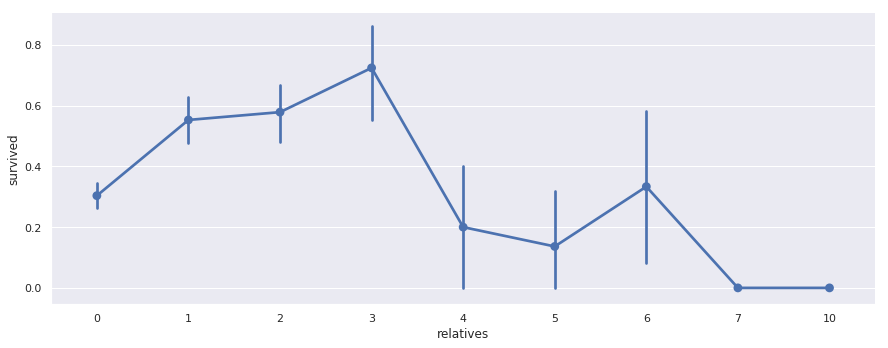

In [265]:
axes = sns.catplot('relatives', 'survived', data=taitan, aspect=2.5, kind='point')

According to the point catplot, passengers with 1 to 3 relatives had higher chances of survival. Those with more than three relatives had lower chances of survival

In [266]:
taitan.title.unique()

array([1, 3, 2, 4, 5])

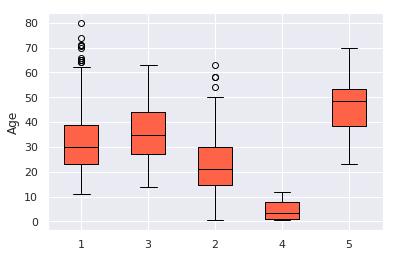

In [267]:
# handling missing values in the age column
# creating a new copy pf taitan dataset name nu_age
nu_age= taitan

# selecting the non-null values only to plot
nnull_age = nu_age [nu_age.age.notnull()]
nnull_list = list(nnull_age.title.unique())

NL = []

for i in range(len(nnull_list)):
  NL.append(list(nnull_age.age[nnull_age.title == nnull_list[i]]))
  

bpfig = plt.boxplot(NL, manage_xticks=True, patch_artist=True)

# 'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Royalty': 5
plt.xticks(np.arange(1,6,1), nnull_list)
plt.ylabel('Age')
plt.setp(bpfig['boxes'], facecolor='tomato')
plt.setp(bpfig['medians'], color='black')
plt.show();

Boxplots reveal that the median age varies depending on title

The outliers were considered to be reasonable and were not removed

In [268]:
# creating a dictionary with the title as the key and median age as the value
# 'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Royalty': 5
med_age = [round(np.median(NL[i])) for i in range(len(NL))]
title_medage = dict(np.transpose([nnull_list, med_age]))
title_medage

{1.0: 30.0, 2.0: 21.0, 3.0: 35.0, 4.0: 4.0, 5.0: 48.0}

I used this dictionary to impute the misssing values in the age column

In [269]:
# filling missing values in the age column with the median
for i in title_medage:
  nu_age.loc[:,'age'][(nu_age.age.isnull()) & (nu_age.title == i)] = float(title_medage[i])
  
nu_age.age.isnull().sum()

# changing the datatype of age column to int
nu_age['age'] = nu_age['age'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0

In [270]:
# handling missing data in embarked column
print('Total no. of missing values:',nu_age.embarked.isnull().sum())
nu_age[nu_age.embarked.isnull()]

Total no. of missing values: 2


,survived,pclass,sex,age,sibsp,parch,fare,embarked,title,relatives,alone
61,1,1,1,38,0,0,80.0,NaN,2,0,1
829,1,1,1,62,0,0,80.0,NaN,3,0,1


In [271]:
nu_age[['fare', 'embarked']][(nu_age.fare >= 80) & (nu_age.fare < 85)]

# class closest to the amount of fare is S

,fare,embarked
34,82.1708,C
61,80.0000,NaN
62,83.4750,S
230,83.4750,S
310,83.1583,C
375,82.1708,C
445,81.8583,S
829,80.0000,NaN
835,83.1583,C
879,83.1583,C


In [272]:
# filling null values in embarked column with S because the fare closest to 80 i.e 81.8583, was for a passenger that embarked at S
nu_age['embarked'] = nu_age['embarked'].fillna('S')
nu_age.embarked.isnull().sum()

0

In [273]:
nu_age.isnull().sum()

survived     0
pclass       0
sex          0
age          0
sibsp        0
parch        0
fare         0
embarked     0
title        0
relatives    0
alone        0
dtype: int64

## Exploratory Data Analysis

In [274]:
# checking a summary of the descriptive statistics of the datframe 
nu_age.describe()

,survived,pclass,sex,age,sibsp,parch,fare,title,relatives,alone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.378227,0.523008,0.381594,32.204208,1.728395,0.904602,0.602694
std,0.486592,0.836071,0.477990,13.271645,1.102743,0.806057,49.693429,1.030039,1.613459,0.489615
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,7.910400,1.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,30.000000,0.000000,0.000000,14.454200,1.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,5.000000,10.000000,1.000000


In [0]:
import warnings 
warnings.filterwarnings('ignore', category=DeprecationWarning)


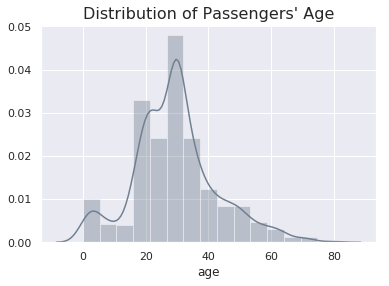

In [276]:
# plotting a histogram to show the distribution of age of passengers
sns.distplot(nu_age['age'].dropna(), bins=15, color='slategrey')
plt.title('Distribution of Passengers\' Age', fontsize=16)
plt.show();

From the distribution, we can conclude that the mean age of passengers is approximately 30 years

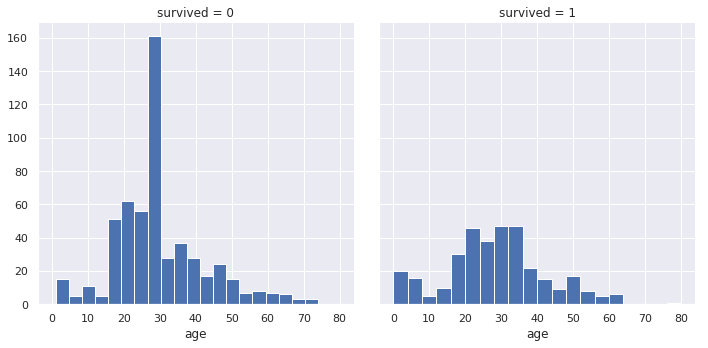

In [277]:
# plotting a multiplot grid showing age distribution of survivors and non-survivors
age_dis = sns.FacetGrid(nu_age, col='survived', height=5)
age_dis.map(plt.hist, 'age', bins=20)
# plt.title('Age Distribution of Survivors and Non-Survivors', pad=40, loc='left')

plt.show();

The distributions above reveal that most of the non-survivors were aged between 20 - 30 years

Most of the survivors were age between 20 - 38 years

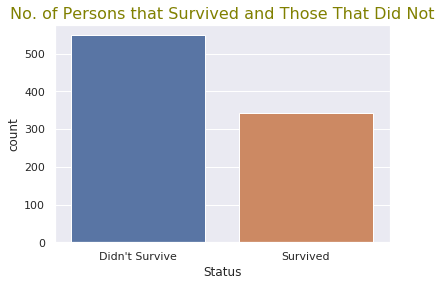

In [278]:
# plotting the no. of passengers that survived and those that did not
sns.countplot(nu_age.survived)
plt.xlabel('Status')
plt.xticks(nu_age.survived, ('Didn\'t Survive', 'Survived'))
plt.title('No. of Persons that Survived and Those That Did Not', fontsize=16, color='olive')
plt.show();


The countplot reveals that most of the passengers did not survive. Approximately 550 pasengers lost their lives and 340 survived.

In [279]:
# checking the exct no. of passengers that survived 
nu_age.survived.value_counts()

0    549
1    342
Name: survived, dtype: int64

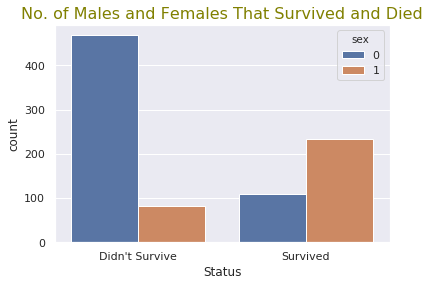

In [280]:
# plotting the value counts of male and female passengers that survived and those that did not 
sns.countplot(nu_age.survived, data=nu_age, hue='sex')
plt.xlabel('Status')
plt.xticks(nu_age.survived, ('Didn\'t Survive', 'Survived'))
plt.title('No. of Males and Females That Survived and Died', fontsize=16, color='olive')
plt.show();

The countplot reveals that most of the passengers that did not survive were male and most of the passenger that survived were female

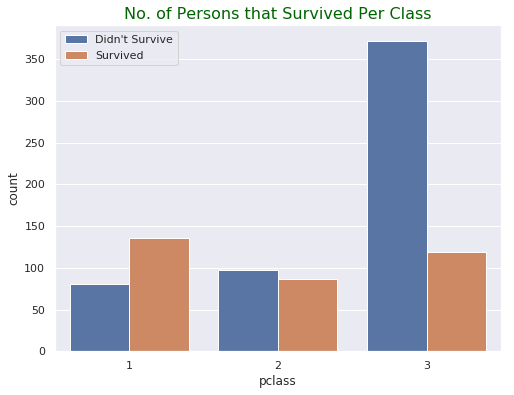

In [281]:
# plotting the no. of passengers that survived per class
plt.figure(figsize=(8,6))
sns.countplot(x='pclass', data=nu_age, hue='survived')
plt.legend(['Didn\'t Survive', 'Survived'])
plt.title('No. of Persons that Survived Per Class', fontsize=16, color='darkgreen')
plt.show();

Countplot reveals that most of the passengers that perished were in the 3rd class.

Most of the survivors were in the first class 

In [282]:
 
# selecting observations where the passengers did not survive
titan_fil =nu_age[nu_age.survived == 0]

# using groupby function to check the total sum of non-survivors per class
titan_fil[['pclass', 'survived']].groupby(['pclass'], as_index= False).count().sort_values('survived', ascending=False)

,pclass,survived
2,3,372
1,2,97
0,1,80


Specifically, 372 persons in the 3rd class perished, 97 in the second class and 80 in the first class.

In [283]:
# using groupby function to check the total sum of non-survivors per class
tf_frame = titan_fil[['pclass', 'survived', 'sex']].groupby(['sex','pclass']).count().reset_index().sort_values('survived', ascending=False)
tf_frame

,sex,pclass,survived
2,0,3,300
1,0,2,91
0,0,1,77
5,1,3,72
4,1,2,6
3,1,1,3


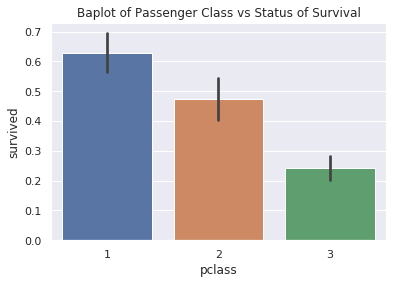

In [284]:
# plotting barplot to show the distribution of chances of survival per pclass

sns.barplot(x='pclass', y='survived', data=nu_age)

plt.title('Baplot of Passenger Class vs Status of Survival')
plt.show();

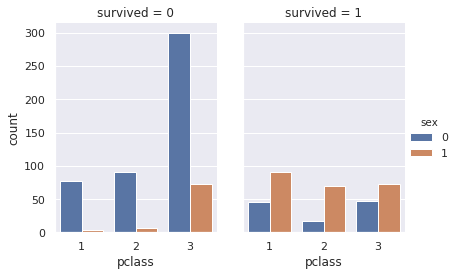

In [285]:
# plotting a catplot to display no. of male and females survived or not in different plots
sns.catplot(x="pclass", hue="sex", col="survived",\
            data=nu_age, kind="count",height=4, aspect=.7);

Catplot reveals that most of the non-survivors (survived=0) were males in the 3rd pclass

Overally, most of the casualties were in the 3rd pclass

Most of the survivors (survived=1) were females in the 1st pclass

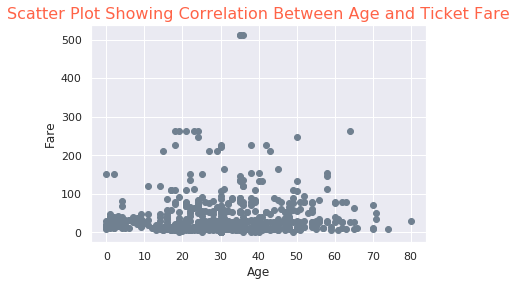

In [286]:
# checking for correlation between age and fare
plt.scatter(nu_age.age, nu_age.fare, color='slategrey')
plt.ylabel('Fare')
plt.xlabel('Age')
plt.title('Scatter Plot Showing Correlation Between Age and Ticket Fare', color='tomato', fontsize=16)
plt.show();

Scatter plot reveals there is no correlation between the two variables.

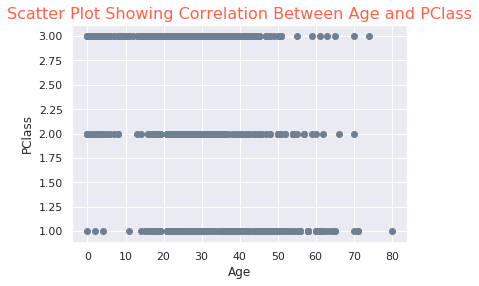

In [287]:
# checking for correlation between age and pclass

plt.scatter(nu_age.age, nu_age.pclass, color='slategrey')
plt.ylabel('PClass')
plt.xlabel('Age')
plt.title('Scatter Plot Showing Correlation Between Age and PClass', color='tomato', fontsize=16)
plt.show();

Scatter does not show any correlation between the two variables

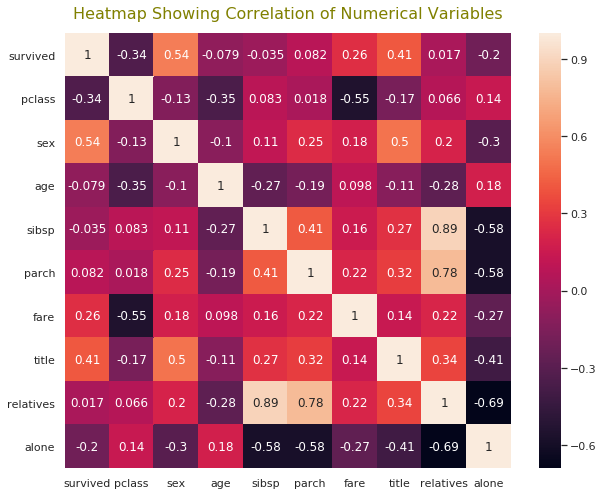

In [288]:
# plotting a heatmap to show the correlation of variables 
plt.figure(figsize=(10,8))
sns.heatmap(nu_age.corr(), annot=True)
plt.title('Heatmap Showing Correlation of Numerical Variables', fontsize=16, color='olive', pad=15)
plt.show();

Heatmap reveals parch and sibsp are highly correlated to relatives column

Dropping the two columns to reduce multicollinearity

In [289]:
# dropping the parch and sibsp columns
nu_age.drop(['parch', 'sibsp'], axis=1, inplace=True)
nu_age.columns

Index(['survived', 'pclass', 'sex', 'age', 'fare', 'embarked', 'title',
       'relatives', 'alone'],
      dtype='object')

## Modelling

In [290]:
# encoding numerical values to values in the embarked column
nu_age['embarked'] = nu_age.embarked.map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
nu_age.head()

,survived,pclass,sex,age,fare,embarked,title,relatives,alone
0,0,3,0,22,7.2500,0,1,1,0
1,1,1,1,38,71.2833,1,3,1,0
2,1,3,1,26,7.9250,0,2,0,1
3,1,1,1,35,53.1000,0,3,1,0
4,0,3,0,35,8.0500,0,1,0,1


In [291]:
# defining our independent variables and dependent variable
features = nu_age.drop('survived', 1).values
target = nu_age['survived'].values

# splitting our data into training and test sets at a ratio of 80:20%
feat_train, feat_test, targ_train, targ_test = train_test_split(features, target, test_size=.2, random_state=34)

print('Feat train shape:', feat_train.shape)
print('Target train shape:', targ_train.shape)
print('Feat test shape:', feat_test.shape)
print('Target test shape:', targ_test.shape)


Feat train shape: (712, 8)
Target train shape: (712,)
Feat test shape: (179, 8)
Target test shape: (179,)


In [0]:
# instantiating the standardscaler object
sscaler = StandardScaler()

# fit and transforming the feat_train 
feat_train = sscaler.fit_transform(feat_train)

# transforming the feat_test
feat_test = sscaler.transform(feat_test)

In [293]:
# instantiating the KNeighbors Classifier with 5 neighbors
kclassif = KNeighborsClassifier(n_neighbors=5, metric='euclidean', n_jobs=-1)

# fitting the model with training data
kclassif.fit(feat_train, targ_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
# making predictions
kpred = kclassif.predict(feat_test)

In [295]:
# Evaluating the Algorithm
# ---
# For evaluating an algorithm, confusion matrix, precision, recall and f1 score are the most commonly used metrics. 
# The confusion_matrix and classification_report methods of the sklearn.metrics can be used to calculate these metrics. 
# ---
# 

print('Confusion Matrix:\n', metrics.confusion_matrix(targ_test, kpred))
print('===='*20)
print('Classification Report:\n', metrics.classification_report(targ_test, kpred))
print('===='*20)
print('Accuracy: %.2f%%'% (metrics.accuracy_score(targ_test, kpred) * 100))
print('===='*20)

Confusion Matrix:
 [[103  15]
 [ 11  50]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89       118
           1       0.77      0.82      0.79        61

    accuracy                           0.85       179
   macro avg       0.84      0.85      0.84       179
weighted avg       0.86      0.85      0.86       179

Accuracy: 85.47%


In [296]:
# Hyperparameter Tuning
# instantiating kfold object with 10 folds
kfold = KFold(n_splits=10, random_state=5)

# creating a dictionary of parameters to be searched for optimal performance of model
params = {'n_neighbors': range(1,5),\
         'metric': ['euclidean', 'manhattan', 'minkowski'],
         'weights': ['uniform', 'distance']}

# instantiating the gridsearchcv object 
grids = GridSearchCV(estimator=KNeighborsClassifier(), 
                     param_grid=params, 
                     cv=kfold, n_jobs=-1)

# fitting the gridsearch with training data
gridmodel = grids.fit(feat_train, targ_train)

# getting the best parameters from the model
gridmodel.best_params_
print('\n' + '===='*20)
# getting the best score from the model
gridmodel.best_score_ * 100
print('\n' + '===='*20)

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}

80.33707865168539

In [297]:
# instantiating knn classifier with parameters from the grid search
knclassifop = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='uniform')

# fitting the model with training data
knclassifop.fit(feat_train, targ_train)

# making predictions 
knop_pred = knclassifop.predict(feat_test)

# print the confusion matrix 
print('\nConfusion Matrix:\n', metrics.confusion_matrix(targ_test, knop_pred))
print('===='*20)
# checking the accuracy score of the optimized model
print('\nAccuracy Score: %.2f%%' % (metrics.accuracy_score(targ_test, knop_pred) * 100))
print('===='*20)
# print classification report
print('Classification report:\n', metrics.classification_report(targ_test, knop_pred))
print('===='*20)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')


Confusion Matrix:
 [[102  16]
 [ 12  49]]

Accuracy Score: 84.36%
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88       118
           1       0.75      0.80      0.78        61

    accuracy                           0.84       179
   macro avg       0.82      0.83      0.83       179
weighted avg       0.85      0.84      0.84       179



Using the parameters obtained from hyperparameter tuning, the accuracy of the optimized knn classifier model decreases to 84.36%



In [298]:
# splitting our data into training and test sets at a ratio of 70:30%
featt_train, featt_test, ttarg_train, ttarg_test = train_test_split(features, target, test_size=.3, random_state=34)

print('Feat train shape:', featt_train.shape)
print('Target train shape:', ttarg_train.shape)
print('Feat test shape:', featt_test.shape)
print('Target test shape:', ttarg_test.shape)


Feat train shape: (623, 8)
Target train shape: (623,)
Feat test shape: (268, 8)
Target test shape: (268,)


In [0]:
# instantiating the standardscaler object
sscalerd = StandardScaler()

# fit and transforming the feat_train 
featt_train = sscalerd.fit_transform(featt_train)

# transforming the feat_test
featt_test = sscalerd.transform(featt_test)

In [300]:
# instantiating the KNeighbors Classifier with 5 neighbors
kclassiff = KNeighborsClassifier(n_neighbors=5, metric='euclidean', n_jobs=-1)

# fitting the model with training data
kclassiff.fit(featt_train, ttarg_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
# making predictions
kpredd = kclassiff.predict(featt_test)

In [302]:
# Evaluating the Algorithm
# ---
# For evaluating an algorithm, confusion matrix, precision, recall and f1 score are the most commonly used metrics. 
# The confusion_matrix and classification_report methods of the sklearn.metrics can be used to calculate these metrics. 
# ---
# 

print('Confusion Matrix:\n', metrics.confusion_matrix(ttarg_test, kpredd))
print('===='*20)
print('Classification Report:\n', metrics.classification_report(ttarg_test, kpredd))
print('===='*20)
print('Accuracy: %.2f%%'% (metrics.accuracy_score(ttarg_test, kpredd) * 100))
print('===='*20)

Confusion Matrix:
 [[153  15]
 [ 23  77]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       168
           1       0.84      0.77      0.80       100

    accuracy                           0.86       268
   macro avg       0.85      0.84      0.85       268
weighted avg       0.86      0.86      0.86       268

Accuracy: 85.82%


In [303]:
# Hyperparameter Tuning
# instantiating kfold object with 10 folds
kkfold = KFold(n_splits=10, random_state=5)

# creating a dictionary of parameters to be searched for optimal performance of model
paramts = {'n_neighbors': range(1,5),\
         'metric': ['euclidean', 'manhattan', 'minkowski'],
         'weights': ['uniform', 'distance']}

# instantiating the gridsearchcv object 
gridss = RandomizedSearchCV(estimator=KNeighborsClassifier(), 
                     param_distributions=paramts, scoring='accuracy',
                     cv=kfold, n_jobs=-1)

# fitting the gridsearch with training data
gridmdel = gridss.fit(featt_train, ttarg_train)

# getting the best parameters from the model
gridmdel.best_params_
print('\n' + '===='*20)
# getting the best score from the model
gridmdel.best_score_ * 100
print('\n' + '===='*20)

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}

78.97271268057786

In [304]:
# instantiating knn classifier with parameters from the grid search
knclassifopt = KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='uniform')

# fitting the model with training data
knclassifopt.fit(featt_train, ttarg_train)

# making predictions 
knopt_pred = knclassifopt.predict(featt_test)

# print the confusion matrix 
print('\nConfusion Matrix:\n', metrics.confusion_matrix(ttarg_test, knopt_pred))
print('===='*20)
# checking the accuracy score of the optimized model
print('\nAccuracy Score: %.2f%%' % (metrics.accuracy_score(ttarg_test, knopt_pred) * 100))
print('===='*20)
# print classification report
print('Classification report:\n', metrics.classification_report(ttarg_test, knopt_pred))
print('===='*20)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')


Confusion Matrix:
 [[156  12]
 [ 38  62]]

Accuracy Score: 81.34%
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86       168
           1       0.84      0.62      0.71       100

    accuracy                           0.81       268
   macro avg       0.82      0.77      0.79       268
weighted avg       0.82      0.81      0.81       268



In [305]:
# splitting our data into training and test sets at a ratio of 60:40%
ffeat_train, ffeat_test, targg_train, targg_test = train_test_split(features, target, test_size=.4, random_state=34)

print('Feat train shape:', ffeat_train.shape)
print('Target train shape:', targg_train.shape)
print('Feat test shape:', ffeat_test.shape)
print('Target test shape:', targg_test.shape)


Feat train shape: (534, 8)
Target train shape: (534,)
Feat test shape: (357, 8)
Target test shape: (357,)


In [0]:
# instantiating the standardscaler object
stscaler= StandardScaler()

# fit and transforming the feat_train 
ffeat_train = stscaler.fit_transform(ffeat_train)

# transforming the feat_test
ffeat_test = stscaler.transform(ffeat_test)

In [307]:
# instantiating the KNeighbors Classifier with 5 neighbors
knclassiff = KNeighborsClassifier(n_neighbors=5, metric='euclidean', n_jobs=-1)

# fitting the model with training data
knclassiff.fit(ffeat_train, targg_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
# making predictions
knpredd = knclassiff.predict(ffeat_test)

In [309]:
print('Confusion Matrix:\n',metrics.confusion_matrix(targg_test, knpredd))
print('===='*20)
print('Classification Report:\n', metrics.classification_report(targg_test, knpredd))
print('===='*20)
print('Accuracy: %.2f%%'% (metrics.accuracy_score(targg_test, knpredd) * 100))
print('===='*20)

Confusion Matrix:
 [[194  33]
 [ 26 104]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87       227
           1       0.76      0.80      0.78       130

    accuracy                           0.83       357
   macro avg       0.82      0.83      0.82       357
weighted avg       0.84      0.83      0.84       357

Accuracy: 83.47%


In [310]:
# Hyperparameter Tuning
# instantiating kfold object with 10 folds
kkfold = KFold(n_splits=10, random_state=5)

# creating a dictionary of parameters to be searched for optimal performance of model
paramets = {'n_neighbors': range(1,5),\
         'metric': ['euclidean', 'manhattan', 'minkowski'],
         'weights': ['uniform', 'distance']}

# instantiating the gridsearchcv object 
gridsse = GridSearchCV(estimator=KNeighborsClassifier(), 
                     param_grid=paramets, 
                     cv=kfold, n_jobs=-1)

# fitting the gridsearch with training data
gridsmdel = gridsse.fit(ffeat_train, targg_train)

# getting the best parameters from the model
gridsmdel.best_params_
print('\n' + '===='*20)
# getting the best score from the model
gridsmdel.best_score_ * 100
print('\n' + '===='*20)

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}

82.20973782771536

In [311]:
# instantiating knn classifier with parameters from the grid search
knnclassifopt = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='uniform')

# fitting the model with training data
knnclassifopt.fit(ffeat_train, targg_train)

# making predictions 
knnopt_pred = knnclassifopt.predict(ffeat_test)

# print the confusion matrix 
print('\nConfusion Matrix:\n', metrics.confusion_matrix(targg_test, knnopt_pred))
print('===='*20)
# checking the accuracy score of the optimized model
print('\nAccuracy Score: %.2f%%' % (metrics.accuracy_score(targg_test, knnopt_pred) * 100))
print('===='*20)
# print classification report
print('Classification report:\n', metrics.classification_report(targg_test, knnopt_pred))
print('===='*20)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')


Confusion Matrix:
 [[184  43]
 [ 26 104]]

Accuracy Score: 80.67%
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84       227
           1       0.71      0.80      0.75       130

    accuracy                           0.81       357
   macro avg       0.79      0.81      0.80       357
weighted avg       0.81      0.81      0.81       357



Test size that recorded the highest accuracy was 0.3

## Challenging The Solution

In [312]:
# random forest 

rforest = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=50)
rforest.fit(feat_train, targ_train)

rfpred = rforest.predict(feat_test)

print('\n'+'===='*20)
rfacc = metrics.accuracy_score(targ_test, rfpred)
rfacc = round(rfacc * 100, 2)
rfacc
print('\n' +'===='*20)
rafacc = rforest.score(feat_train, targ_train)
rafacc = round(rafacc * 100, 2)
rafacc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

88.27

84.69

In [313]:
# logistic regression
logreg = LogisticRegression()
logreg.fit(feat_train, targ_train)

# making predictions
logpred = logreg.predict(feat_test)

print('\n'+'===='*20)
logacc = metrics.accuracy_score(targ_test, logpred)
logacc = round(logacc * 100, 2)
logacc
print('\n' +'===='*20)
logtacc = logreg.score(feat_train, targ_train)
logtacc = round(logtacc * 100, 2)
logtacc

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

84.92

80.76

In [314]:
# xgboost classifier
xgb = XGBClassifier(random_State=50, n_estimators=100)
xgb.fit(feat_train, targ_train)

xgbpred = xgb.predict(feat_test)

print('\n'+'===='*20)
xgbacc = metrics.accuracy_score(targ_test, xgbpred)
xgbacc = round(xgbacc * 100, 2)
xgbacc
print('\n' +'===='*20)
xgbtacc = xgb.score(feat_train, targ_train)
xgbtacc = round(xgbtacc * 100, 2)
xgbtacc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_State=50,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

87.15

88.48

In [315]:
# naive bayes using gaussian
gauss = GaussianNB()
gauss.fit(feat_train, targ_train)

gausspred = gauss.predict(feat_test)

print('\n'+'===='*20)
gacc = metrics.accuracy_score(targ_test, gausspred)
gacc = round(gacc * 100, 2)
gacc
print('\n' +'===='*20)
gtacc = gauss.score(feat_train, targ_train)
gtacc = round(gtacc * 100, 2)
gtacc

GaussianNB(priors=None, var_smoothing=1e-09)

84.36

79.49

In [316]:
# creating a dataframe with two columns: model and test accuracy score
results = pd.DataFrame({'Model': ['Naive Bayes Gaussian', 'Random Forest', 'XGBoost', 'Logistic Regression'],
                      'Test Accuracy Score': [gacc, rfacc, xgbacc, logacc]})
# sorting the datframe by the values in the test accuracy score column
results.sort_values('Test Accuracy Score', ascending=False, inplace=True)

results

,Model,Test Accuracy Score
1,Random Forest,88.27
2,XGBoost,87.15
3,Logistic Regression,84.92
0,Naive Bayes Gaussian,84.36


XGBoost and Random forest classifiers exhibit higher accuracy than the knn classifier. The two may be considered in place of a knn classifier



In [317]:
# evaluating the performance of the random forest classifier

# instantiating the classifier
rfc = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=-1, random_state=50)

# getting the cross val score of the model with the training set
scores = cross_val_score(rfc, feat_train, targ_train, cv=10, scoring='accuracy', n_jobs=-1)
print('Scores:', scores)
print('===='*20)

print('Mean:', scores.mean())
print('===='*20)
print('Standard Deviation:', scores.std())
print('===='*20)

Scores: [0.82191781 0.77464789 0.8028169  0.84507042 0.81690141 0.83098592
 0.83098592 0.74647887 0.85915493 0.78873239]
Mean: 0.8117692456106502
Standard Deviation: 0.03236345716719157


In [318]:
scores.std()/scores.mean() * 100

3.9867803987629866

The std is approximately 3.9%, meaning that the accuracy of the model can differ by roughly 4%

## Conclusion

We get the highest accuracy when the ratio of train and test sets is 80:20

The knn classifier performs fairly well in predicting the chances of passengers survival in case of an accident, with an accuracy of 84.92%

We can get better predictions by using the random forest classifier as the prediction model.